In [15]:
source("wwa_model-fitting.R")

---
## **Fitting different models**

### **GEV fitted to maximum temperatures**

In [2]:
tmax <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_tasmax.dat", comment.char = "#", sep = " ", col.names = c("year", "tmax")))

tmax_shift <- fit_ns("gev", "shift", tmax, "tmax", "gmst")

gmst_2022 <- tmax$gmst[tmax$year == 2022]

In [2]:
# get model parameters & results at given covariate level
boot_ci(tmax_shift, cov = gmst_2022, cov_cf = gmst_2022 - 1.2, nsamp = 100)

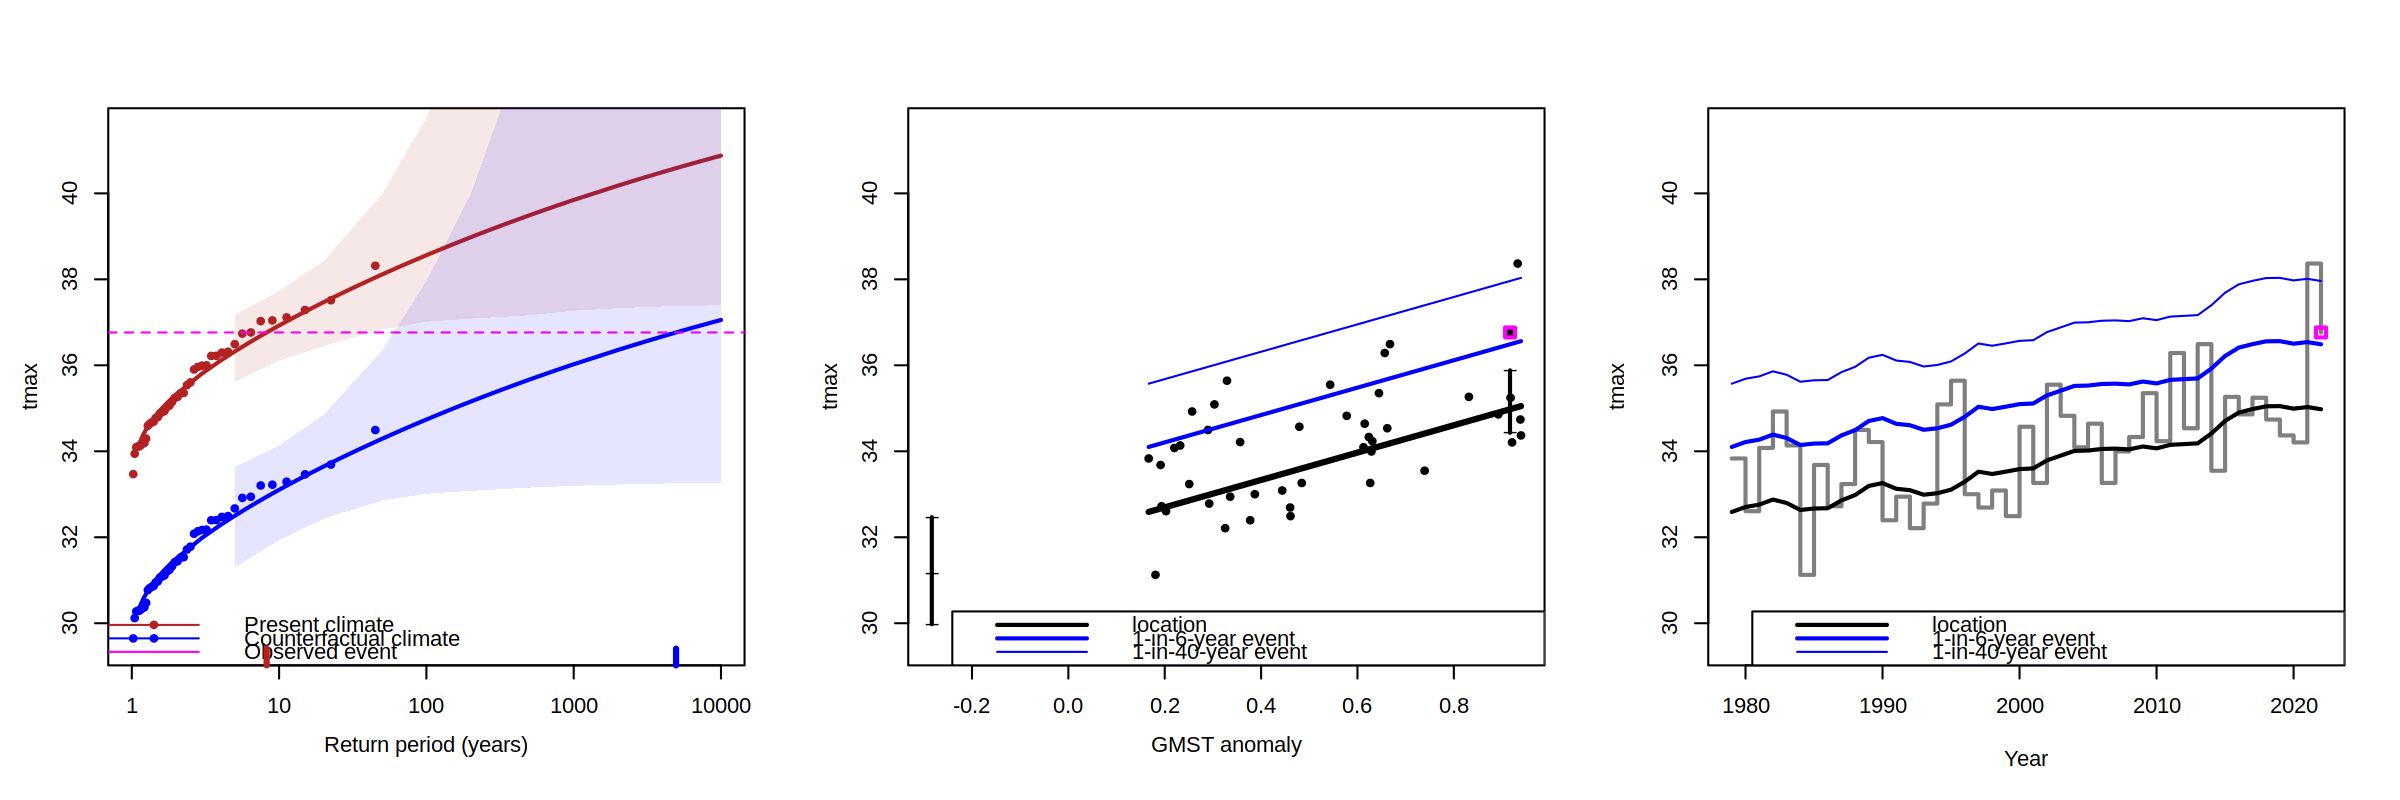

In [12]:
# plot fitted model results
prep_window(c(1,3))

ylim <- c(29.5, 41.5)

plot_returnlevels(tmax_shift, cov = gmst_2022, cov_cf = gmst_2022 - 1.2, ylim = ylim, legend_pos = "bottomright")
plot_gmsttrend(tmax_shift, cov = gmst_2022, cov_cf = gmst_2022 - 1.2, ylim = ylim, legend_pos = "bottomright")
plot_trend(tmax_shift, legend_pos = "bottomright", ylim = ylim)

### **Gaussian fitted to log precip**

In [14]:
pr <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
            read.csv("data/test_precip.dat", comment.char = "#", sep = " ", col.names = c("year", "pr")))

# take log of precip - column name should begin with log10 (or log if taking natural log)
# log10 used here for consistency with climate explorer
pr$log10_pr <- log10(pr$pr)

# specify whether to look at upper or lower tail (default is upper)
pr_fd <- fit_ns("norm", "fixeddisp", pr, "log10_pr", "gmst", lower = T)

gmst_2022 <- pr$gmst[pr$year == 2022]

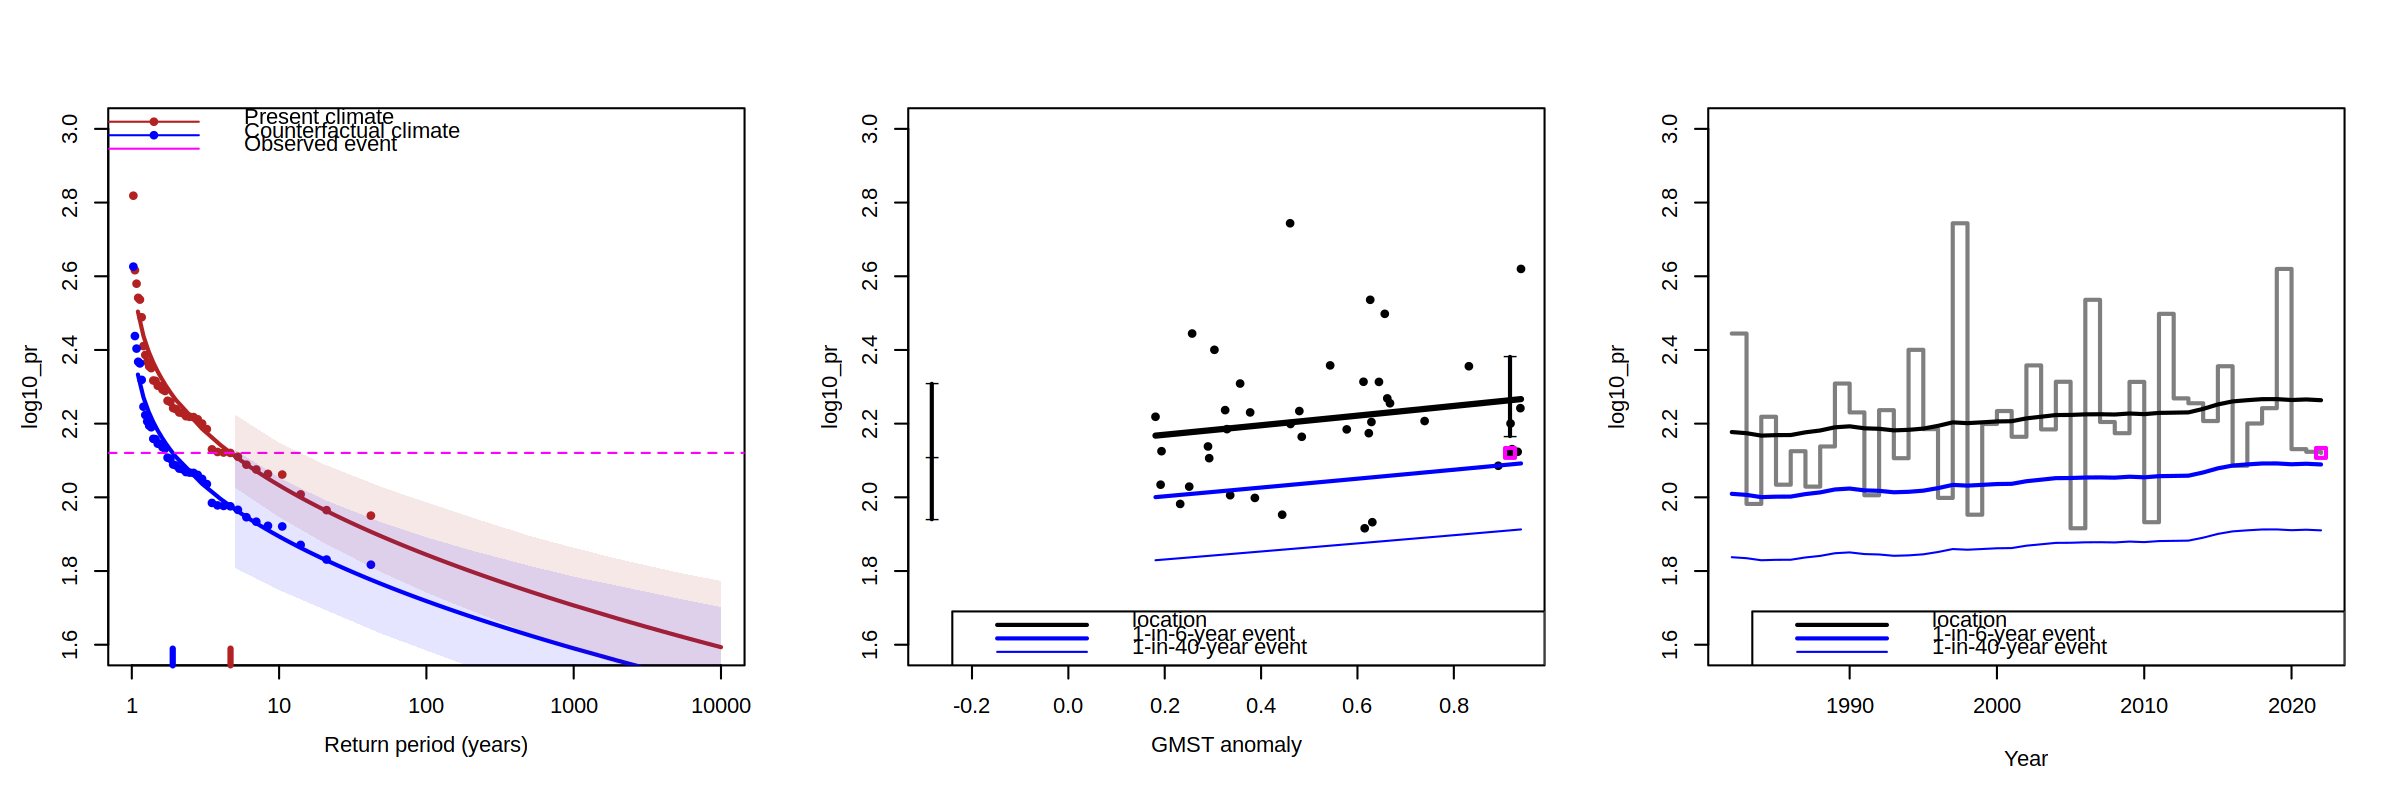

In [17]:
# plot fitted model results
prep_window(c(1,3))

ylim <- c(1.6,3)

plot_returnlevels(pr_fd, cov = gmst_2022, cov_cf = gmst_2022 - 1.2, ylim = ylim, legend_pos = "topright")
plot_gmsttrend(pr_fd, cov = gmst_2022, cov_cf = gmst_2022 - 1.2, ylim = ylim, legend_pos = "bottomright")
plot_trend(pr_fd, legend_pos = "bottomright", ylim = ylim)

### **GEV fitted to minimum temperatures**

In [18]:
tmin <- merge(read.csv("data/test_gmst.dat", comment.char = "#", sep = " ", col.names = c("year", "gmst")),
              read.csv("data/test_tasmin.dat", comment.char = "#", sep = " ", col.names = c("year", "tmin")))

# when looking at minimum temps, fitting has to be done to -temps for reasons of numerical stability: flag this using 'mintemps'
# also not looking at the latest year: event year in this case is 1962, so record this when fitting model
tmin_shift <- fit_ns("gev", "shift", tmin, "tmin", "gmst", lower = T, mintemps = T, event_index = which(tmin$year == 1962))

# this time, compare 1962 climate with 2022
gmst_1962 <- tmin$gmst[tmin$year == 1962]
gmst_2022 <- tmin$gmst[tmin$year == 2022]

In [23]:
# get model parameters & results at given confidence interval
boot_ci(tmin_shift, cov = gmst_1962, cov_cf = gmst_2022, nsamp = 100)

,bestimate,2.5%,97.5%
mu0,-0.19766,-0.61001,2.496400e-01
sigma0,1.49142,1.19242,1.671200e+00
alpha,2.39397,1.54688,3.318080e+00
shape,-0.12087,-0.23458,9.182000e-02
disp,-7.54538,-35.86710,9.253127e+01
event_magnitude,-6.34776,-6.34776,-6.347760e+00
return_period,332.11411,43.53197,2.321828e+09
PR,33.97735,3.54424,Inf
dI_abs,-2.12349,-2.94318,-1.372110e+00
dI_rel,50.26870,27.59721,8.650773e+01


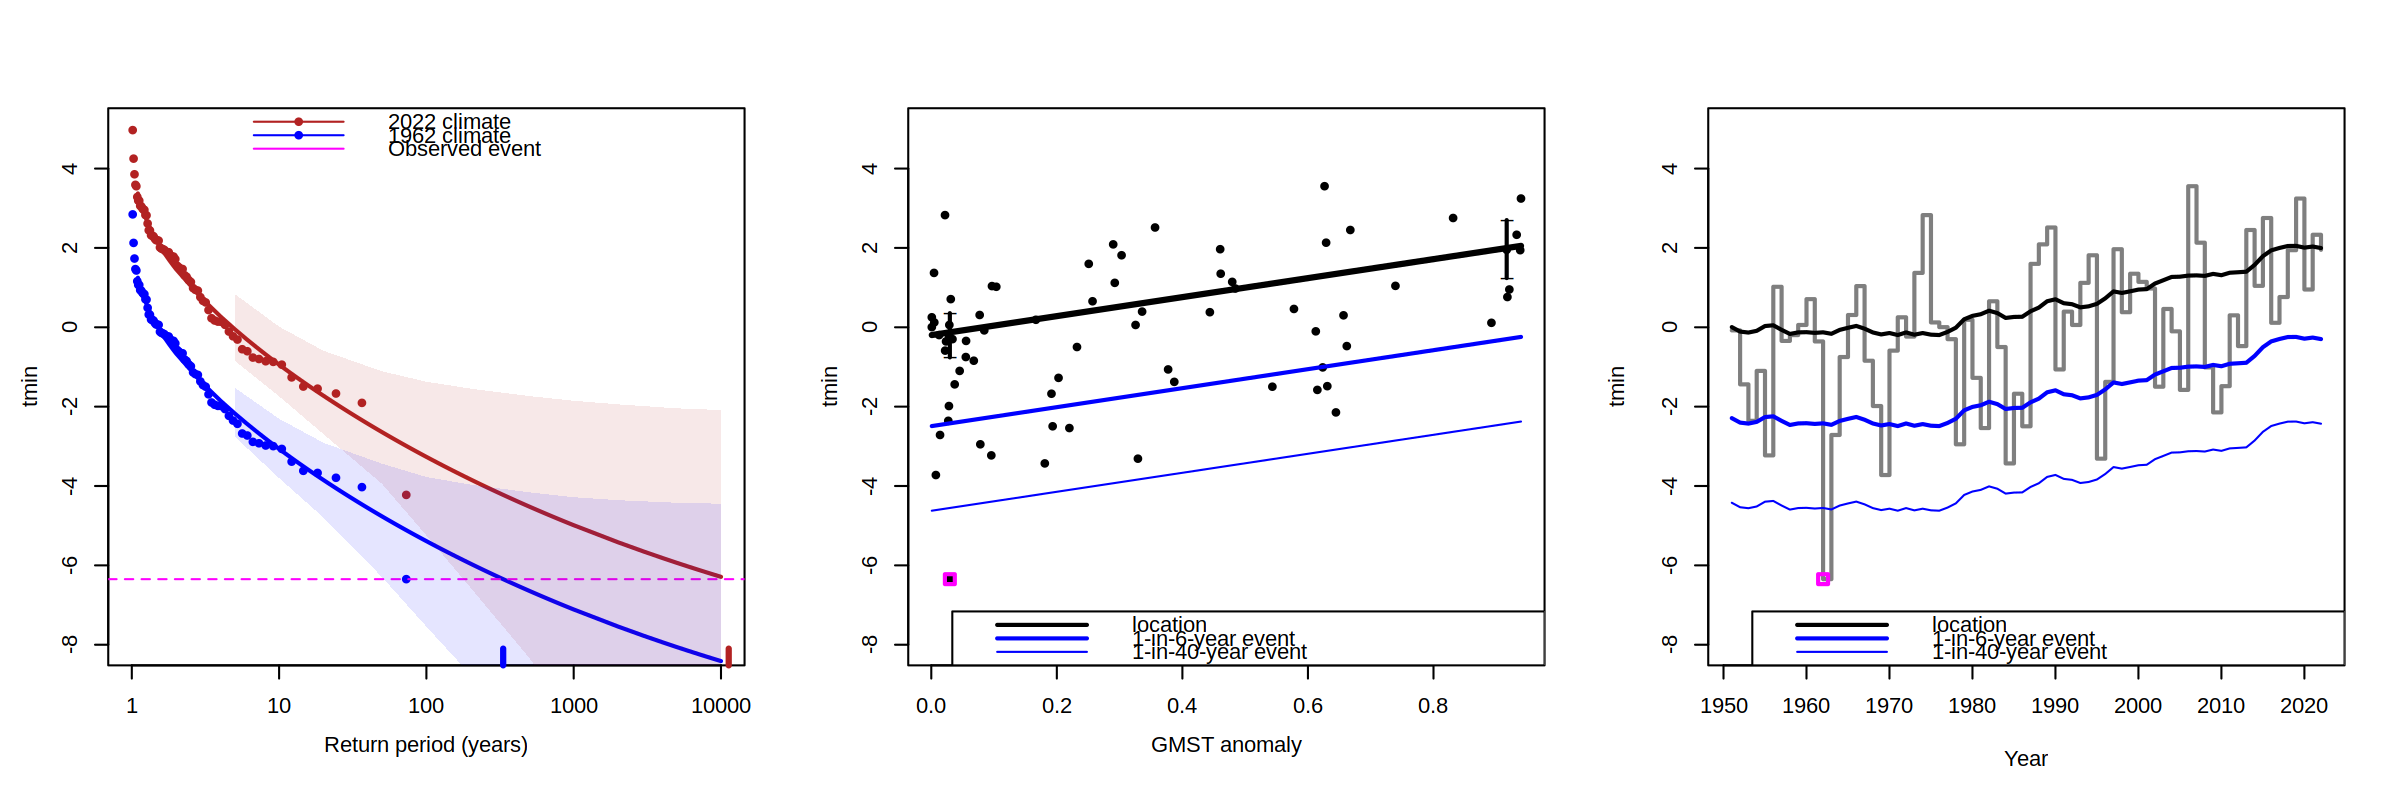

In [22]:
# plot fitted model results
prep_window(c(1,3))

ylim <- c(-8, 5)

# can also modify the legend labels
plot_returnlevels(tmin_shift, cov = gmst_2022, cov_cf = gmst_1962, ylim = ylim, legend_pos = "topright", legend_labels = c("2022 climate", "1962 climate"))
plot_gmsttrend(tmin_shift, cov = gmst_2022, cov_cf = gmst_1962, ylim = ylim, legend_pos = "bottomright")
plot_trend(tmin_shift, legend_pos = "bottomright", ylim = ylim)

## **Producing results for spreadsheet**

### **CORDEX models**

In [32]:
source("wwa_model-fitting.R")

# loop over all available models, get results for each
invisible(sapply(list.files("data", pattern = "rx21day-amj_EUR-11", full.names = T)[1], function(fnm) {
    
    # results will be saved in a .csv file, one per model
    res_fnm <- paste0("res/res_",gsub("data/", "", gsub(".dat", "", fnm)), ".csv")
    print(fnm)
    if(!file.exists(res_fnm)) {   # won't replace any files that already exist - have to delete manually first
        
        # identify the correct GMST file
        gmst_fnm <- list.files("data", paste0("smoothed-gsat_", strsplit(fnm, "_")[[1]][4], "_rcp85_", strsplit(fnm, "_")[[1]][5], ".dat"), full.names = T)
        
        # load data & merge into single dataframe
        var <- read.csv(fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "var"))
        gmst <- read.csv(gmst_fnm, comment.char = "#", sep = " ", header = F, col.names = c("year", "gmst"))
        df <- merge(gmst, var)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # SPECIFY MODEL TO BE ANALYSED
        
        # return period of event
        rp <- 10
        
        # value of covariate in present/factual climate
        event_cov <- df[df$year == 2023, "gmst"]
        
        # fit the model - this is used as a template for the attribution
        mdl <- fit_ns("norm", "fixeddisp", df, "var", "gmst", lower = F, mintemps = F, event_index = which(df$year == 2023))
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # get model results & save as .csv
        res_df <- cmodel_results(mdl, rp = rp, cov_pres = event_cov, nsamp = 50)
        rownames(res_df) <- gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][4:6], collapse = "_"))
        write.csv(res_df, res_fnm)
    }
}))

[1] "data/Italy-floods_rx21day-amj_EUR-11_CNRM-CM5_r1_HadREM3-GA7-05.dat"
bestimate      2.5%     97.5% 
  0.30030   0.26825   0.30152 


In [323]:
# compile into single file 
res <- do.call("rbind", sapply(list.files("res", pattern = "EUR-11", full.names = T), read.csv, row.names = 1, simplify = F))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][5:7], collapse = "_")))
write.csv(res, "res/cordex-results.csv")